**Reasoning**:
Gather all the previously defined functions for image processing, segmentation, feature extraction, object detection helpers, and image transformations into a single code cell for better organization and reusability.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/projects/image-processing-toolkit/

[Errno 2] No such file or directory: '/content/drive/MyDrive/projects/image-processing-toolkit/'
/content


In [3]:
!pip install opencv-python-headless matplotlib numpy

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Create results folder (will be used later to save images for GitHub)
os.makedirs("results", exist_ok=True)
os.makedirs("images", exist_ok=True)


## Organize the code

### Subtask:
Consolidate all function definitions into a single code cell.

In [17]:
# Function definitions for image processing techniques

def show_side_by_side(images, titles, cmap_flags=None, save_name=None):
    """
    Display multiple images side by side.
    images: list of images (RGB or grayscale)
    titles: list of titles for each image
    cmap_flags: list of bools (True if grayscale)
    save_name: if provided, saves the figure in /results
    """
    n = len(images)
    plt.figure(figsize=(5*n, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        cmap = "gray" if (cmap_flags and cmap_flags[i]) else None
        plt.imshow(images[i], cmap=cmap)
        plt.title(titles[i])
        plt.axis("off")
    if save_name:
        plt.savefig(f"results/{save_name}", bbox_inches="tight")
    plt.show()

def erode_image(image, kernel):
    """
    Applies erosion to an image.
    Erosion is a morphological operation that shrinks or thins shapes in a binary image.
    It is typically applied using a structuring element or kernel.
    """
    return cv2.erode(image, kernel, iterations=1)

def dilate_image(image, kernel):
    """
    Applies dilation to an image.
    Dilation is a morphological operation that grows or thickens shapes in a binary image.
    It is the opposite of erosion and is also applied using a structuring element or kernel.
    """
    return cv2.dilate(image, kernel, iterations=1)

def open_image(image, kernel):
    """
    Applies morphological opening to an image.
    Opening is a morphological operation that is erosion followed by dilation.
    It is useful for removing small objects from an image while preserving the shape and size of larger objects.
    """
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def close_image(image, kernel):
    """
    Applies morphological closing to an image.
    Closing is a morphological operation that is dilation followed by erosion.
    It is useful for closing small holes inside the foreground objects, or small black points on the object.
    """
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

def simple_threshold(gray_image, threshold_value):
    """
    Applies simple binary thresholding to a grayscale image.
    Pixels with intensity values above the threshold_value are set to 255 (white),
    and pixels below or equal to the threshold_value are set to 0 (black).
    """
    _, thresh_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY)
    return thresh_image

def convert_color_space(image, color_space='HSV'):
    """
    Converts an image to a different color space.
    Supports conversion to HSV and LAB color spaces.
    """
    if color_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    else:
        return image # Return original if color space is not supported or specified

def fourier_transform(gray_image):
    """
    Computes and visualizes the 2D DFT (Discrete Fourier Transform) of a grayscale image.
    The magnitude spectrum shows the frequency components of the image.
    """
    dft = cv2.dft(np.float32(gray_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)
    # Calculate the magnitude spectrum and apply log scale for better visualization
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
    return magnitude_spectrum

def kmeans_segmentation(image, n_clusters):
    """
    Segments an image using K-means clustering.
    image: input image (RGB or grayscale)
    n_clusters: number of clusters for K-means
    returns: segmented image
    """
    # Reshape the image to be a list of pixels for K-means
    pixel_values = image.reshape((-1, 3)) if len(image.shape) == 3 else image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    # Define criteria and apply kmeans()
    # cv2.TERM_CRITERIA_EPS: stop the algorithm when the accuracy is met
    # cv2.TERM_CRITERIA_MAX_ITER: stop the algorithm after a specified number of iterations
    # 100: maximum number of iterations
    # 0.2: epsilon (required accuracy)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    k = n_clusters
    # Apply K-means clustering
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_PP_CENTERS)

    # Convert back to 8 bit values for the centers
    centers = np.uint8(centers)

    # Flatten the labels to create the segmented image
    labels = labels.flatten()

    # Create the segmented image by replacing pixel values with their cluster center
    segmented_image = centers[labels.flatten()]

    # Reshape back to original image dimensions
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

def otsu_thresholding(gray_image):
    """
    Applies Otsu's thresholding to a grayscale image.
    Otsu's method automatically determines the optimal threshold value by maximizing the variance between two classes of pixels.
    gray_image: input grayscale image
    returns: binary segmented image
    """
    # Apply Otsu's thresholding
    # cv2.THRESH_BINARY: creates a binary image (0 or 255)
    # cv2.THRESH_OTSU: applies Otsu's method
    _, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return otsu_thresh


def extract_sift_features(gray_image):
    """Extracts SIFT keypoints and descriptors from a grayscale image."""
    # Initialize SIFT detector
    sift = cv2.SIFT_create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)
    return keypoints, descriptors

def extract_orb_features(gray_image):
    """Extracts ORB keypoints and descriptors from a grayscale image."""
    # Initialize ORB detector
    orb = cv2.ORB_create()
    # Detect keypoints and compute descriptors
    keypoints, descriptors = orb.detectAndCompute(gray_image, None)
    return keypoints, descriptors

def extract_hog_features(gray_image):
    """Extracts HOG features from a grayscale image."""
    # Define HOG parameters
    winSize = (64, 64)
    blockSize = (16, 16)
    blockStride = (8, 8)
    cellSize = (8, 8)
    nbins = 9
    # Initialize HOG descriptor
    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins)

    # Compute HOG features
    features = hog.compute(gray_image, winStride=(8,8))

    return features

def rotate_image(image, angle):
    """Rotates an image by a given angle."""
    # Get image dimensions
    (h, w) = image.shape[:2]
    # Calculate the center of the image
    center = (w // 2, h // 2)
    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    # Perform the rotation
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

def flip_image(image, flip_code):
    """Flips an image horizontally (1), vertically (0), or both (-1)."""
    return cv2.flip(image, flip_code)


def scale_image(image, scale_factor):
    """Scales an image by a given factor."""
    # Get image dimensions
    (h, w) = image.shape[:2]
    # Calculate new dimensions
    new_w = int(w * scale_factor)
    new_h = int(h * scale_factor)
    # Perform resizing (scaling)
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA) # INTER_AREA is good for shrinking
    return resized

def translate_image(image, tx, ty):
    """Translates an image by (tx, ty) pixels."""
    # Define the translation matrix
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    # Get image dimensions
    (h, w) = image.shape[:2]
    # Perform the translation
    translated = cv2.warpAffine(image, M, (w, h))
    return translated

def perspective_transform(image, src_points, dst_points):
    """Applies a perspective transformation to an image."""
    # Get the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    # Get image dimensions
    (h, w) = image.shape[:2]
    # Perform the perspective transformation
    warped = cv2.warpPerspective(image, M, (w, h))
    return warped

def crop_image(image, x, y, width, height):
    """Crops an image to the specified region (x, y, width, height)."""
    # Perform cropping
    cropped = image[y:y+height, x:x+width]
    return cropped

def resize_image(image, new_width, new_height):
    """Resizes an image to the specified dimensions."""
    # Perform resizing
    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized

# Adding adjust_brightness_contrast function here again to ensure it's present
def adjust_brightness_contrast(image, brightness=0, contrast=0):
    """Adjusts the brightness and contrast of an image."""
    # Convert to float for calculations
    dtype = image.dtype
    image = np.int16(image)
    # Apply brightness and contrast adjustments
    image = image * (contrast/127 + 1) - contrast + brightness
    # Clip values to the valid range (0-255 for 8-bit images)
    image = np.clip(image, 0, 255)
    # Convert back to original data type
    image = np.uint8(image)
    return image


# Helper functions for object detection (feature matching)
def match_features(query_image, train_image):
    """
    Finds matching features between two grayscale images using SIFT and a FLANN-based Matcher,
    filters matches, finds homography, and draws bounding box if object is found.
    Includes suggested improvements for logo detection.
    query_image: grayscale image of the object to find
    train_image: grayscale image where the object is expected to be
    returns: tuple of (image with drawn matches and bounding box, boolean indicating if object was found)
    """
    # Preprocess the query image by applying Canny edge detection
    # This can help SIFT detect features on the logo's edges more effectively.
    query_image_processed = cv2.Canny(query_image, 100, 200)


    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Find the keypoints and descriptors with SIFT in both images
    kp1, des1 = sift.detectAndCompute(query_image_processed, None) # Use processed query image
    kp2, des2 = sift.detectAndCompute(train_image, None)

    # Ensure descriptors are float32 for FLANN
    des1 = np.float32(des1)
    des2 = np.float32(des2)

    # FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Find k=2 best matches
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test (relaxed)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance: # Relaxed ratio
            good_matches.append(m)

    # Minimum number of good matches to find the object
    min_match_count = 4 # Lowered minimum match count

    # Draw all good matches with rich keypoints for visualization clarity
    img_matches = cv2.drawMatches(query_image, kp1, train_image, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

    object_found = False # Flag to indicate if object was found

    if len(good_matches) >= min_match_count: # Changed condition to >=
        # Get the keypoints from the good matches
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        # Find the homography matrix using RANSAC
        # Increased RANSAC tolerance
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.0)

        # Get the dimensions of the query image
        h, w = query_image.shape

        # Get the corners of the query image
        corners = np.float32([ [0,0],[w-1,0],[w-1,h-1],[0,h-1] ]).reshape(-1,1,2)

        # Project the corners onto the training image using the homography
        if M is not None:
            transformed_corners = cv2.perspectiveTransform(corners, M)

            # Draw the bounding box on the training image part of the matches image
            # The offset is the width of the query image
            img_matches = cv2.polylines(img_matches, [np.int32(transformed_corners) + (w, 0)], True, (0,255,0), 3, cv2.LINE_AA)
            object_found = True # Set flag to True
            print("Object Found!") # Keep print for notebook execution
        else:
            print("Object Not Clearly Found - Homography calculation failed.") # Keep print for notebook execution

    else:
        print(f"Object Not Clearly Found - Not enough good matches ({len(good_matches)}/{min_match_count})") # Keep print for notebook execution

    return img_matches, object_found # Return image and status flag

# Helper function for object detection (template matching)
def template_matching(query_image, train_image):
    """
    Performs template matching to find the location of a query image (template) within a training image.
    query_image: grayscale image of the object to find (template)
    train_image: grayscale image where the object is expected to be (search image)
    returns: tuple of (image with a rectangle drawn around the best match, confidence score)
    """
    # Get the dimensions of the query image (template)
    w, h = query_image.shape[::-1]

    # Perform template matching using TM_CCOEFF_NORMED method
    # This method uses correlation coefficient and is generally reliable
    res = cv2.matchTemplate(train_image, query_image, cv2.TM_CCOEFF_NORMED)

    # Find the location of the best match
    # min_val, max_val, min_loc, max_loc
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # Define a confidence threshold for template matching
    # This threshold can be adjusted based on testing
    confidence_threshold = 0.6 # Example threshold

    object_found = False # Flag to indicate if object was found

    if max_val >= confidence_threshold:
        # Get the top-left corner of the best match area
        top_left = max_loc
        # Calculate the bottom-right corner
        bottom_right = (top_left[0] + w, top_left[1] + h)

        # Draw a rectangle around the best match area on a copy of the training image
        train_image_display = cv2.cvtColor(train_image, cv2.COLOR_GRAY2RGB) # Convert to color to draw colored rectangle
        cv2.rectangle(train_image_display, top_left, bottom_right, (0, 255, 0), 3) # Green rectangle with thickness 3

        object_found = True # Set flag to True
        print(f"Object Found! Confidence: {max_val:.2f}") # Keep print for notebook execution
    else:
        train_image_display = cv2.cvtColor(train_image, cv2.COLOR_GRAY2RGB) # Return original image in color
        print(f"Object Not Found. Best match confidence: {max_val:.2f}") # Keep print for notebook execution


    return train_image_display, max_val # Return image and confidence score (can be used as status)

Upload an image file (jpg/png)...


Saving images.jpeg to images.jpeg


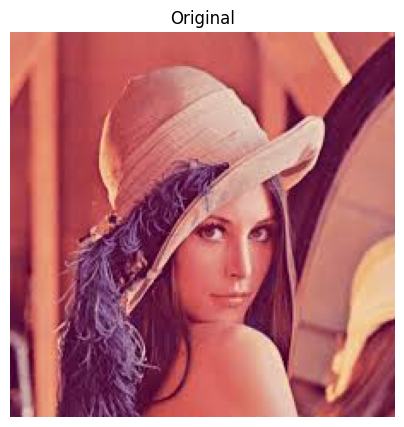

In [5]:

from google.colab import files

print("Upload an image file (jpg/png)...")
uploaded = files.upload()

filename = list(uploaded.keys())[0]
img = cv2.imread(filename)

# Convert BGR → RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_side_by_side([img_rgb], ["Original"], [False], save_name="original.png")


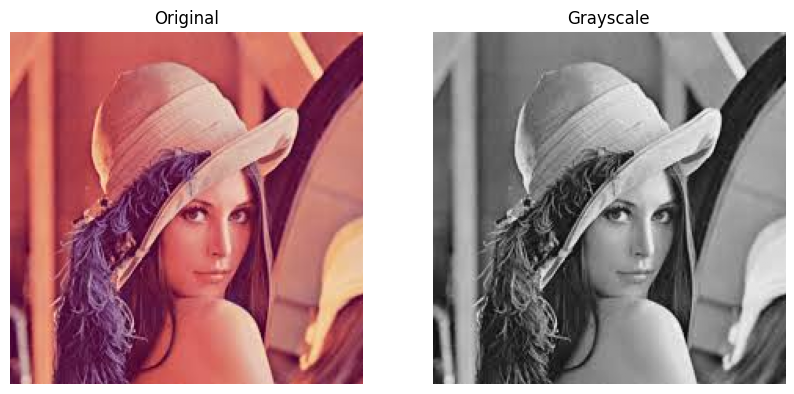

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show_side_by_side([img_rgb, gray],
                  ["Original", "Grayscale"],
                  [False, True],
                  save_name="grayscale.png")


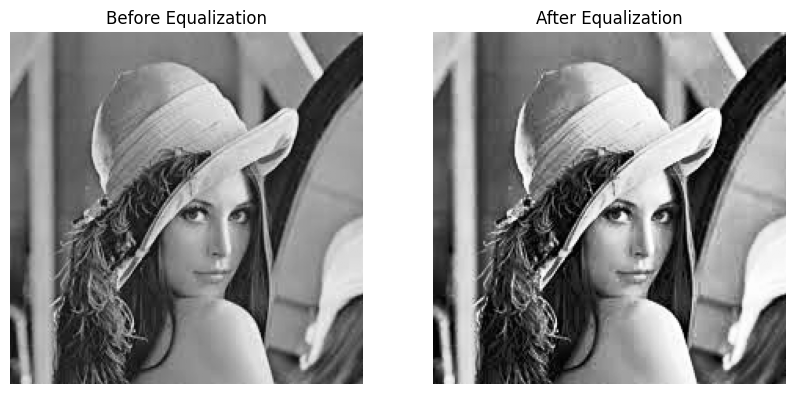

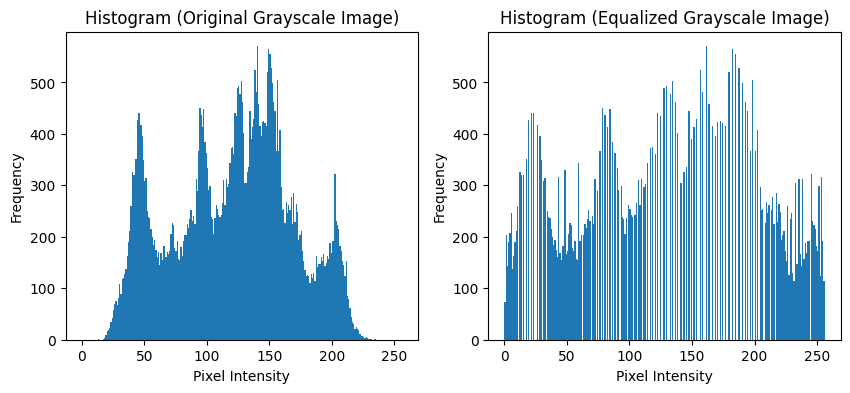

In [7]:
gray_eq = cv2.equalizeHist(gray)

show_side_by_side([gray, gray_eq],
                  ["Before Equalization", "After Equalization"],
                  [True, True],
                  save_name="histogram_equalization.png")

# Histograms
plt.figure(figsize=(10,4))
# Histogram of the original grayscale image
plt.subplot(1,2,1)
plt.hist(gray.ravel(), bins=256, range=[0,256])
plt.title("Histogram (Original Grayscale Image)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

# Histogram of the equalized grayscale image
plt.subplot(1,2,2)
plt.hist(gray_eq.ravel(), bins=256, range=[0,256])
plt.title("Histogram (Equalized Grayscale Image)")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")

plt.savefig("results/histograms.png")
plt.show()

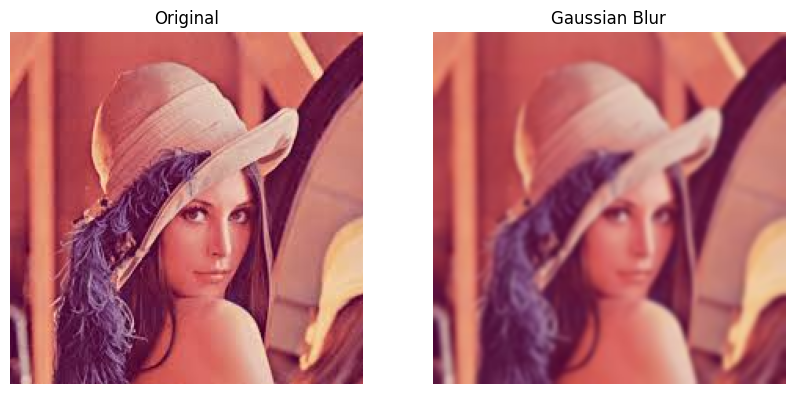

In [8]:
blurred = cv2.GaussianBlur(img_rgb, (7,7), 0)

show_side_by_side([img_rgb, blurred],
                  ["Original", "Gaussian Blur"],
                  [False, False],
                  save_name="gaussian_blur.png")


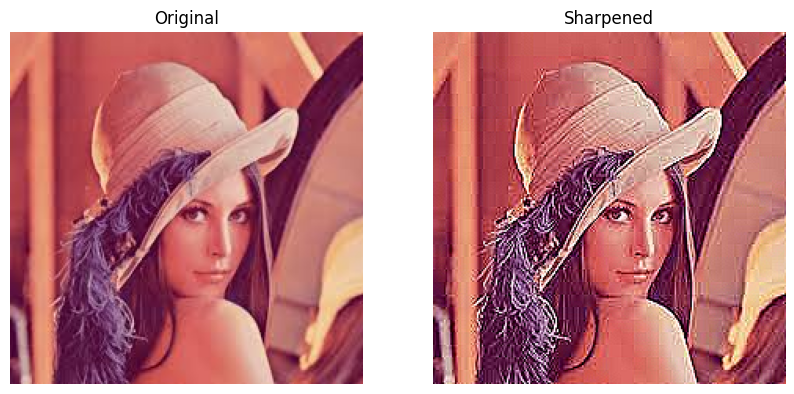

In [9]:
sharpen_kernel = np.array([[0,-1,0],
                           [-1,5,-1],
                           [0,-1,0]])
sharpened = cv2.filter2D(img_rgb, -1, sharpen_kernel)

show_side_by_side([img_rgb, sharpened],
                  ["Original", "Sharpened"],
                  [False, False],
                  save_name="sharpened.png")


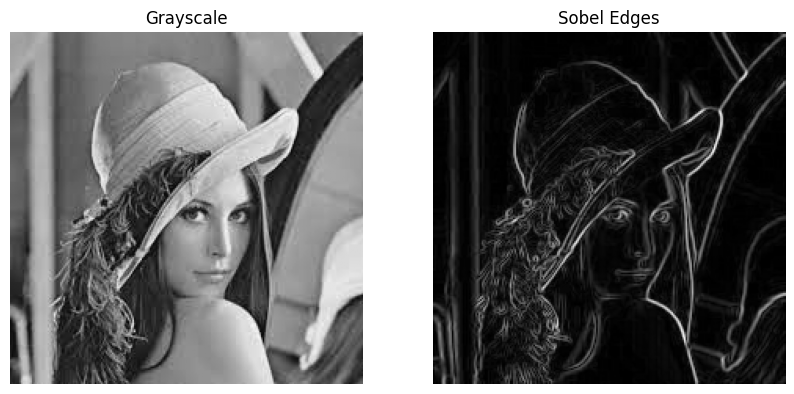

In [10]:
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobel_x, sobel_y)

show_side_by_side([gray, sobel],
                  ["Grayscale", "Sobel Edges"],
                  [True, True],
                  save_name="sobel_edges.png")


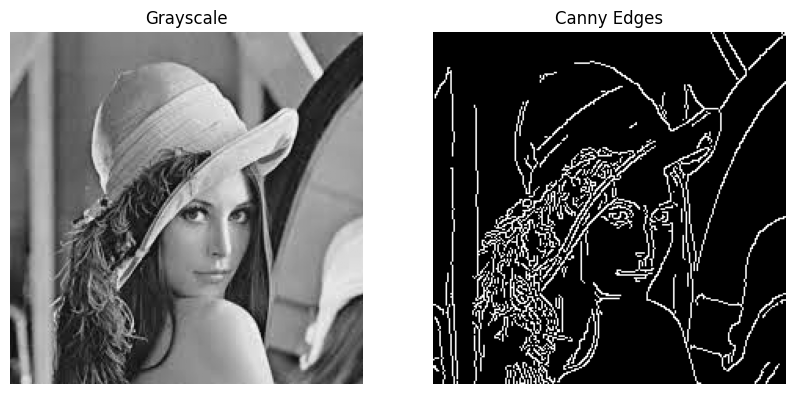

In [11]:
canny = cv2.Canny(gray, 100, 200)

show_side_by_side([gray, canny],
                  ["Grayscale", "Canny Edges"],
                  [True, True],
                  save_name="canny_edges.png")


## Expand image processing techniques

### Subtask:
Introduce more advanced image processing operations beyond the current ones (grayscale, histogram equalization, blur, sharpen, edge detection). This could include morphological operations (erosion, dilation, opening, closing), image thresholding, color space manipulation, and frequency domain analysis.


**Reasoning**:
Implement functions for basic morphological operations (erosion and dilation), morphological opening and closing, simple image thresholding, color space conversion, and basic frequency domain analysis using OpenCV.



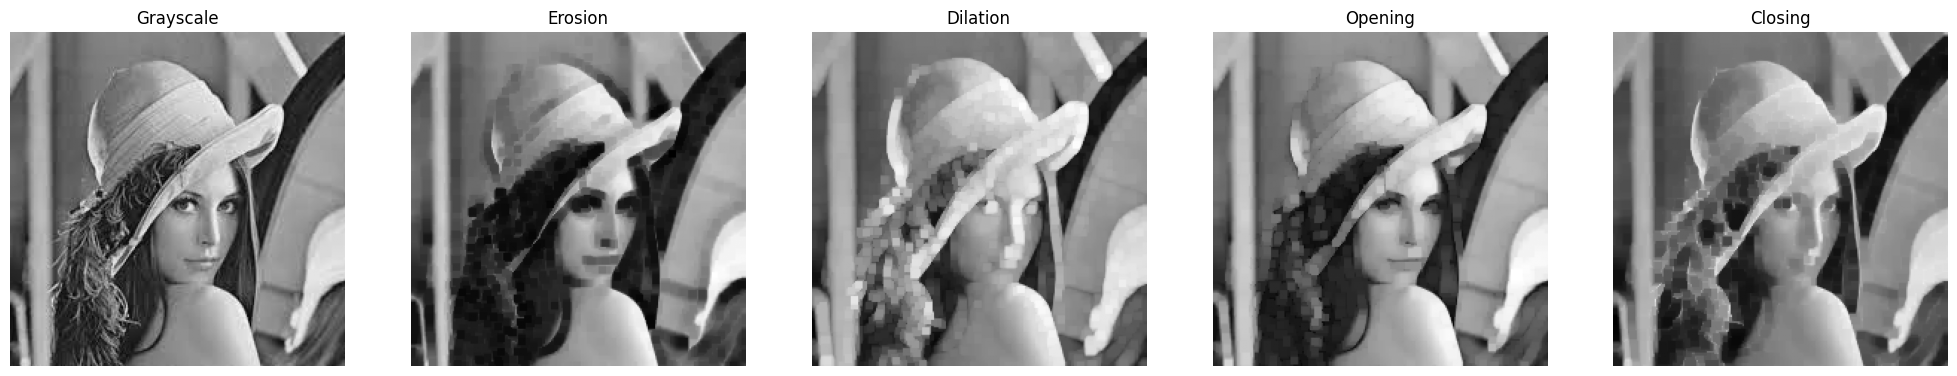

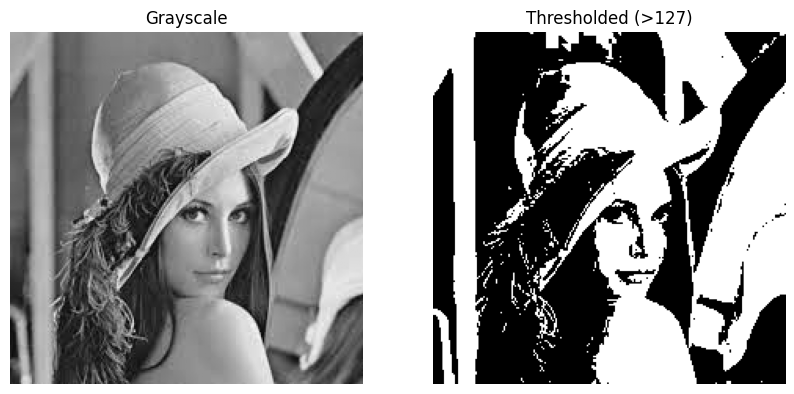

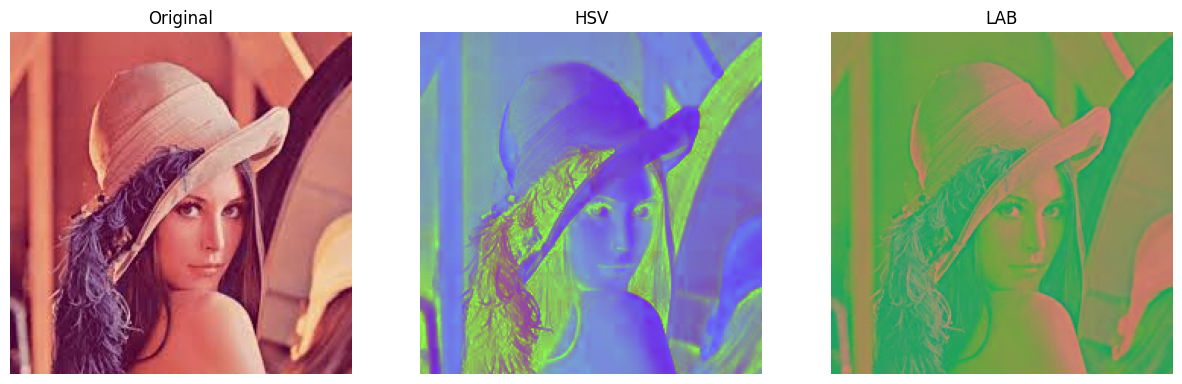

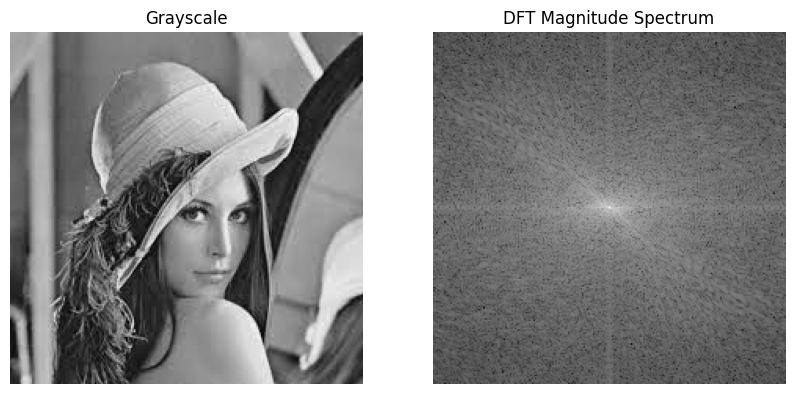

In [12]:
# Create a kernel for morphological operations. A 5x5 square kernel is used here.
kernel = np.ones((5,5), np.uint8)

# Apply morphological operations to the grayscale image
eroded = erode_image(gray, kernel)
dilated = dilate_image(gray, kernel)
opened = open_image(gray, kernel)
closed = close_image(gray, kernel)

# Display the results of morphological operations side by side
show_side_by_side([gray, eroded, dilated, opened, closed],
                  ["Grayscale", "Erosion", "Dilation", "Opening", "Closing"],
                  [True, True, True, True, True],
                  save_name="morphological_operations.png")

# Define a threshold value for simple thresholding
threshold_value = 127
# Apply simple binary thresholding to the grayscale image
thresh = simple_threshold(gray, threshold_value)

# Display the result of simple thresholding side by side
show_side_by_side([gray, thresh],
                  ["Grayscale", f"Thresholded (>{threshold_value})"],
                  [True, True],
                  save_name="thresholding.png")

# Convert the original RGB image to different color spaces
hsv_img = convert_color_space(img_rgb, color_space='HSV') # Convert to HSV
lab_img = convert_color_space(img_rgb, color_space='LAB') # Convert to LAB

# Display the images in different color spaces side by side
show_side_by_side([img_rgb, hsv_img, lab_img],
                  ["Original", "HSV", "LAB"],
                  [False, False, False],
                  save_name="color_spaces.png")

# Perform Fourier Transform on the grayscale image
dft_magnitude = fourier_transform(gray)

# Display the grayscale image and its DFT magnitude spectrum side by side
show_side_by_side([gray, dft_magnitude],
                  ["Grayscale", "DFT Magnitude Spectrum"],
                  [True, True],
                  save_name="fourier_transform.png")

**Reasoning**:
Test the implemented advanced image processing functions using the uploaded image and display the results side by side.



## Introduce image segmentation

### Subtask:
Implement techniques to segment the image into different regions or objects. This could involve methods like K-means clustering, Otsu's thresholding, or more advanced techniques like watershed segmentation.


**Reasoning**:
Implement the functions for K-means clustering and Otsu's thresholding, and then apply these functions to the appropriate images and display the results side-by-side.



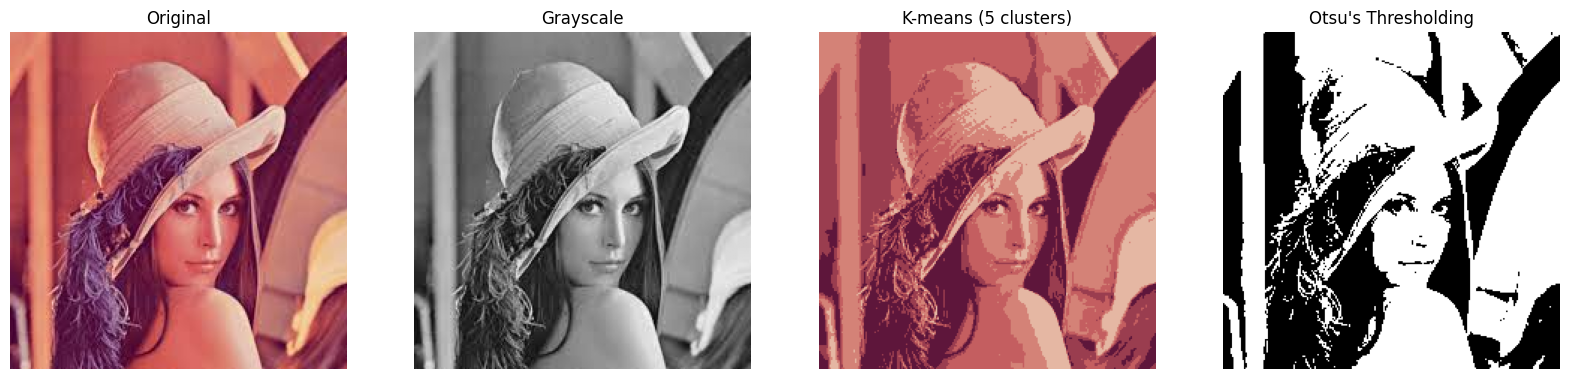

In [13]:
# Apply K-means segmentation to the original color image
n_clusters = 5 # Define the number of clusters
kmeans_segmented = kmeans_segmentation(img_rgb, n_clusters)

# Apply Otsu's thresholding to the grayscale image
otsu_segmented = otsu_thresholding(gray)

# Display the results of the segmentation techniques side by side
show_side_by_side([img_rgb, gray, kmeans_segmented, otsu_segmented],
                  ["Original", "Grayscale", f"K-means ({n_clusters} clusters)", "Otsu's Thresholding"],
                  [False, True, False, True],
                  save_name="image_segmentation.png")

## Add feature extraction

### Subtask:
Include methods to extract meaningful features from images, such as SIFT, SURF, ORB, or HOG descriptors. These features can be used for tasks like object recognition or image retrieval.


**Reasoning**:
Implement functions to extract SIFT, ORB, and HOG features and visualize them, then apply these functions to the grayscale image and display the results side by side.



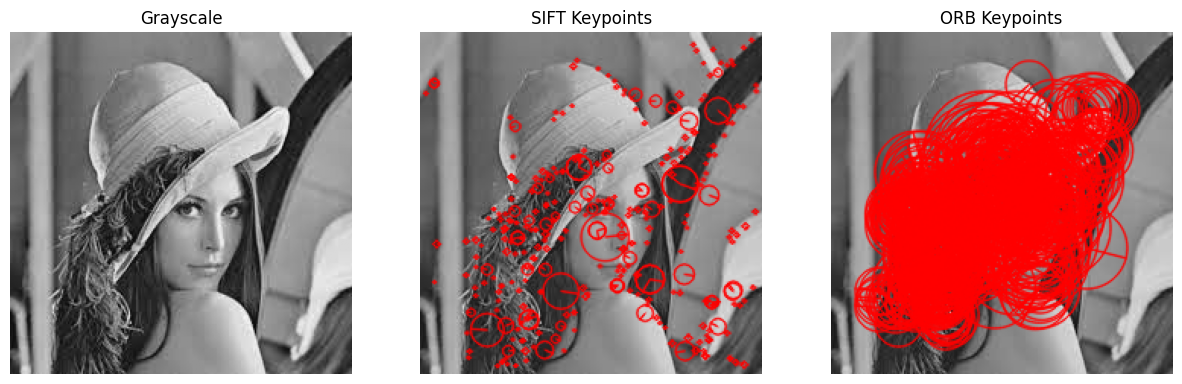

Number of SIFT keypoints: 319
Shape of SIFT descriptors: (319, 128)
Number of ORB keypoints: 406
Shape of ORB descriptors: (406, 32)
Shape of HOG features: (777924,)


In [14]:
# Apply feature extraction to the grayscale image
sift_keypoints, sift_descriptors = extract_sift_features(gray)
orb_keypoints, orb_descriptors = extract_orb_features(gray)
hog_features = extract_hog_features(gray)

# Note: HOG visualization is complex and currently not implemented in this function.
# The hog_features variable contains the extracted descriptors.


# Visualize SIFT and ORB keypoints on the grayscale image
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS draws a circle with the size of the keypoint and shows its orientation
img_sift_kp = cv2.drawKeypoints(gray, sift_keypoints, None, color=(255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_orb_kp = cv2.drawKeypoints(gray, orb_keypoints, None, color=(255,0,0), flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)

# Display the grayscale image and the images with visualized SIFT and ORB keypoints side by side
show_side_by_side([gray, img_sift_kp, img_orb_kp],
                  ["Grayscale", "SIFT Keypoints", "ORB Keypoints"],
                  [True, False, False],
                  save_name="feature_extraction_viz.png")

# Print the number of keypoints and the shape of descriptors and HOG features
print(f"Number of SIFT keypoints: {len(sift_keypoints)}")
print(f"Shape of SIFT descriptors: {sift_descriptors.shape if sift_descriptors is not None else 'None'}")
print(f"Number of ORB keypoints: {len(orb_keypoints)}")
print(f"Shape of ORB descriptors: {orb_descriptors.shape if orb_descriptors is not None else 'None'}")
print(f"Shape of HOG features: {hog_features.shape if hog_features is not None else 'None'}")

## Implement object detection or recognition

### Subtask:
Implement a basic object detection example using feature matching.

**Reasoning**:
Implement a function to perform feature matching between two images using ORB features and a Brute-Force Matcher, and then apply this function to demonstrate object detection.

Upload a query image (the object you want to find)...


Saving obj.jpg to obj.jpg
Upload a training image (the image where you expect to find the object)...


Saving search.jpg to search.jpg
Object Found!


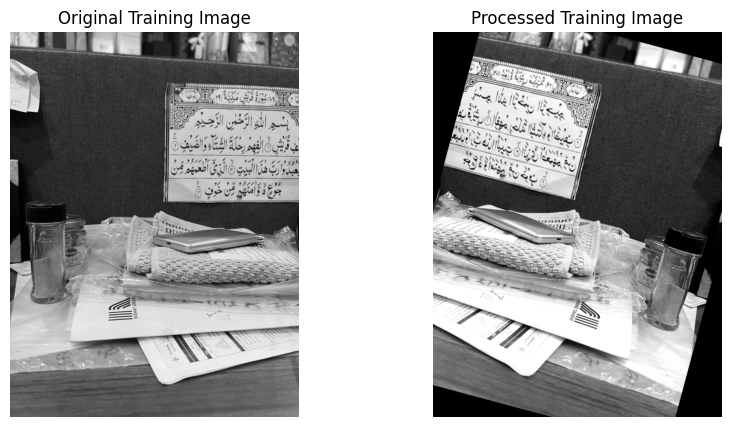

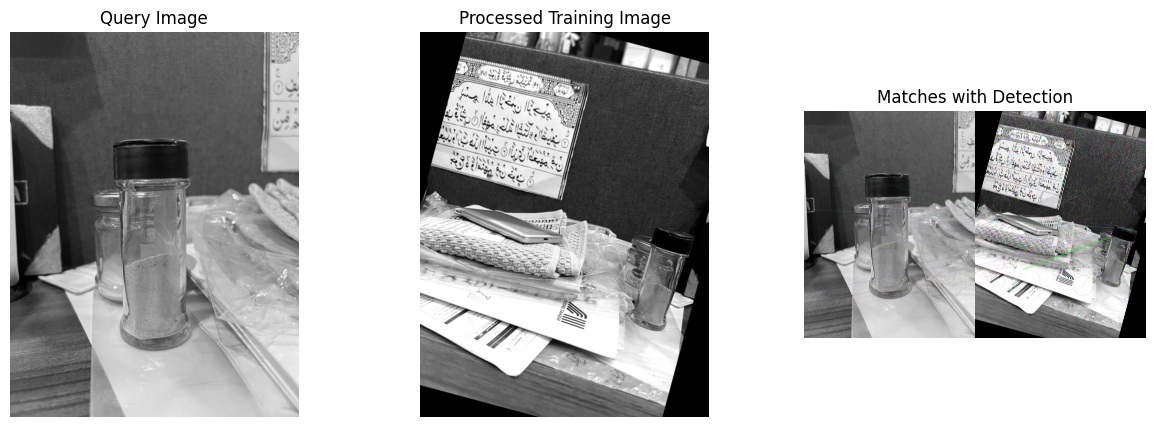

Object Detection Status: Object Found!


In [19]:
# The necessary imports are already at the top of the consolidated function cell (05592f79)
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from google.colab import files

# Check if flip_image is defined and is a callable function (for troubleshooting NameError)
if 'flip_image' not in globals() and 'flip_image' not in locals():
    print("Error: 'flip_image' function is not defined. Please ensure the cell containing function definitions (cell 05592f79) has been executed.")
elif not callable(flip_image):
     print(f"Error: 'flip_image' is defined but is not a callable function. Its type is: {type(flip_image)}. Please check the definition in cell 05592f79.")
else:
    # print("'flip_image' function is available and callable.") # Commented out troubleshooting print
    # print(f"Type of flip_image: {type(flip_image)}") # Commented out troubleshooting print
    # Continue with the rest of the cell execution

    print("Upload a query image (the object you want to find)...")
    uploaded_query = files.upload()
    query_filename = list(uploaded_query.keys())[0]
    img_query = cv2.imread(query_filename, cv2.IMREAD_GRAYSCALE) # Read as grayscale

    print("Upload a training image (the image where you expect to find the object)...")
    uploaded_train = files.upload()
    train_filename = list(uploaded_train.keys())[0]
    img_train = cv2.imread(train_filename, cv2.IMREAD_GRAYSCALE) # Read as grayscale

    # Apply preprocessing techniques to the training image
    # Moderate rotation (e.g., 15 degrees)
    img_train_processed = rotate_image(img_train, 15)
    # Horizontal flip
    img_train_processed = flip_image(img_train_processed, 1)
    # Slight brightness and contrast adjustment
    img_train_processed = adjust_brightness_contrast(img_train_processed, brightness=20, contrast=30)


    # Perform feature matching and object detection on the processed training image
    img_matches_with_box, object_found = match_features(img_query, img_train_processed) # match_features now returns status

    # Convert the resulting image from BGR to RGB for Matplotlib display
    img_matches_with_box_rgb = cv2.cvtColor(img_matches_with_box, cv2.COLOR_BGR2RGB)


    # Display the original training image and the processed training image
    show_side_by_side([img_train, img_train_processed],
                      ["Original Training Image", "Processed Training Image"],
                      [True, True],
                      save_name="processed_training_image.png")

    # Display the image with matches and potentially a bounding box (using the processed training image)
    # Pass the RGB version of the matches image to show_side_by_side
    show_side_by_side([img_query, img_train_processed, img_matches_with_box_rgb],
                  ["Query Image", "Processed Training Image", "Matches with Detection"],
                  [True, True, False], # The last image is now color (RGB)
                  save_name="feature_matching_detection_processed.png")

    # Print the object detection status explicitly
    if object_found:
        print("Object Detection Status: Object Found!")
    else:
        print("Object Detection Status: Object Not Found.")

## Include image transformation and manipulation

### Subtask:
Add capabilities for geometric transformations (rotation, scaling, translation, perspective transformations) and other manipulations like cropping or resizing.

**Important:** Please ensure that the cell containing the consolidated function definitions (cell `05592f79`) is executed before running this cell. This cell relies on the functions defined in cell `05592f79`.

**Reasoning**:
Implement functions for various image transformation and manipulation techniques using OpenCV and apply them to the uploaded image to demonstrate their usage.

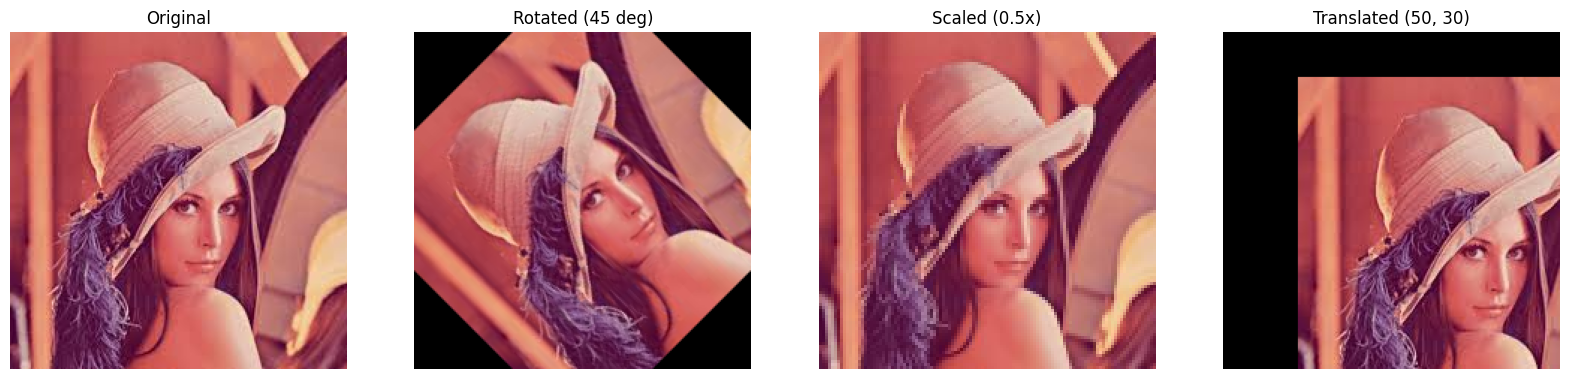

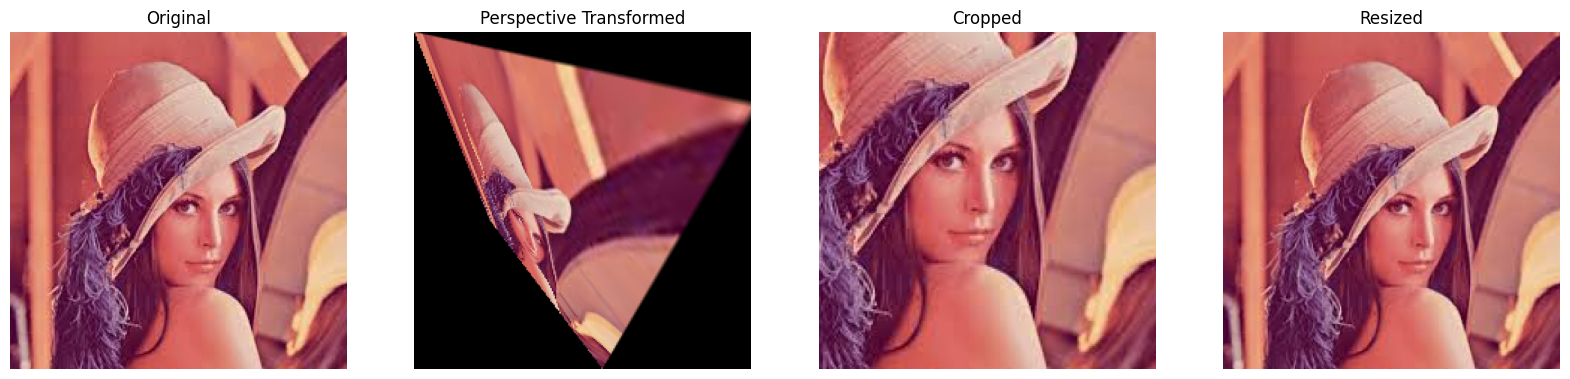

In [20]:
# Example Usage: Apply transformations and manipulations to the original RGB image (img_rgb)

# Rotate the image by 45 degrees
rotated_img = rotate_image(img_rgb, 45)

# Scale the image to half its size
scaled_img = scale_image(img_rgb, 0.5)

# Translate the image by 50 pixels to the right and 30 pixels down
translated_img = translate_image(img_rgb, 50, 30)

# Define source and destination points for a perspective transformation
# These points define a rectangle in the source image and where its corners will map to in the destination
(h, w) = img_rgb.shape[:2]
src_pts = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])
# Example: map to a skewed rectangle
dst_pts = np.float32([[0, 0], [w - 1, 50], [w - 100, h - 1], [50, h - 100]])

# Apply perspective transformation
warped_img = perspective_transform(img_rgb, src_pts, dst_pts)

# Crop the image (example: crop a 200x200 region starting at (50, 50))
crop_x, crop_y, crop_w, crop_h = 50, 50, 200, 200
cropped_img = crop_image(img_rgb, crop_x, crop_y, crop_w, crop_h)

# Resize the image to a new dimension (e.g., 300x300)
new_width, new_height = 300, 300
resized_img = resize_image(img_rgb, new_width, new_height)


# Display the results of the transformations and manipulations with titles
show_side_by_side([img_rgb, rotated_img, scaled_img, translated_img],
                  ["Original", "Rotated (45 deg)", "Scaled (0.5x)", "Translated (50, 30)"],
                  [False, False, False, False],
                  save_name="geometric_transformations_1.png")

show_side_by_side([img_rgb, warped_img, cropped_img, resized_img],
                  ["Original", "Perspective Transformed", "Cropped", "Resized"],
                  [False, False, False, False],
                  save_name="geometric_transformations_2.png")

## Integrate with machine learning

### Subtask:
Implement a basic image classification example using a pre-trained model.

**Reasoning**:
Use a pre-trained convolutional neural network model to classify the content of an image. This demonstrates how machine learning can be applied to image understanding.

In [21]:
import numpy as np
import cv2
from google.colab import files
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array

# Load the pre-trained ResNet50 model
# weights='imagenet' loads weights pre-trained on the ImageNet dataset
model = ResNet50(weights='imagenet')

# The ResNet50 model expects input images to be of size 224x224
img_size = (224, 224)

# Add image upload functionality
print("Upload an image for classification (jpg/png)...")
uploaded_ml = files.upload()

if uploaded_ml:
    filename_ml = list(uploaded_ml.keys())[0]
    img_classify = cv2.imread(filename_ml)

    # Convert BGR to RGB as Keras models expect RGB input
    img_classify_rgb = cv2.cvtColor(img_classify, cv2.COLOR_BGR2RGB)

    # Preprocess the uploaded image for the model
    img_ml_processed = cv2.resize(img_classify_rgb, img_size)  # Resize the image
    img_ml_processed = img_to_array(img_ml_processed)  # Convert the image to a NumPy array
    img_ml_processed = np.expand_dims(img_ml_processed, axis=0)  # Add a batch dimension
    img_ml_processed = preprocess_input(img_ml_processed)  # Preprocess for ResNet50

    # Make predictions
    predictions = model.predict(img_ml_processed)

    # Decode the predictions to get human-readable labels
    decoded_predictions = decode_predictions(predictions, top=5)[0]

    # Print the top predictions
    print("\nPredictions for the uploaded image:")
    for imagenet_id, label, score in decoded_predictions:
        print(f"- {label}: {score:.2f}")

    # Optional: Display the uploaded image
    # show_side_by_side([img_classify_rgb], ["Uploaded Image for Classification"])

else:
    print("No image uploaded for classification.")


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Upload an image for classification (jpg/png)...


Saving testing image.jpeg to testing image.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Predictions for the uploaded image:
- running_shoe: 0.92
- Loafer: 0.03
- shoe_shop: 0.02
- sandal: 0.01
- clog: 0.00


## Implement object detection or recognition

### Subtask:
Implement a basic object detection example using feature matching.

**Reasoning**:
Implement a function to perform feature matching between two images using ORB features and a Brute-Force Matcher, and then apply this function to demonstrate object detection.

Upload a query image (the object you want to find - template)...


Saving images.jpeg to images (1).jpeg
Upload a training image (the image where you expect to find the object - search image)...


Saving images.jpeg to images (2).jpeg
Object Found! Confidence: 1.00


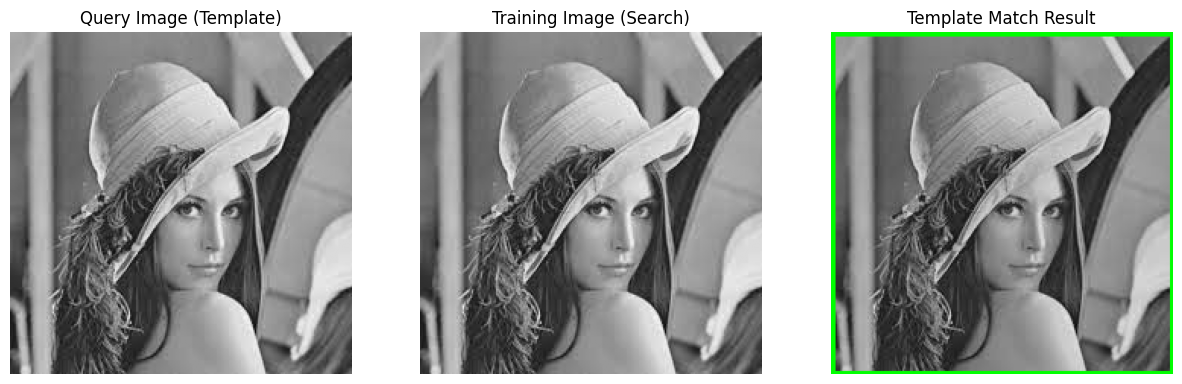

Template Matching Status: Object Found! Confidence: 1.00


In [28]:
# The necessary imports are already at the top of the consolidated function cell (05592f79)
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from google.colab import files

print("Upload a query image (the object you want to find - template)...")
uploaded_query_temp = files.upload()
query_filename_temp = list(uploaded_query_temp.keys())[0]
img_query_temp = cv2.imread(query_filename_temp, cv2.IMREAD_GRAYSCALE) # Read as grayscale

print("Upload a training image (the image where you expect to find the object - search image)...")
uploaded_train_temp = files.upload()
train_filename_temp = list(uploaded_train_temp.keys())[0]
img_train_temp = cv2.imread(train_filename_temp, cv2.IMREAD_GRAYSCALE) # Read as grayscale


# Perform template matching
img_template_match, confidence = template_matching(img_query_temp, img_train_temp) # template_matching now returns confidence

# Convert the resulting image from BGR to RGB for Matplotlib display
img_template_match_rgb = cv2.cvtColor(img_template_match, cv2.COLOR_BGR2RGB)

# Display the images and the result of template matching
# Pass the RGB version of the template match result to show_side_by_side
show_side_by_side([img_query_temp, img_train_temp, img_template_match_rgb],
                  ["Query Image (Template)", "Training Image (Search)", "Template Match Result"],
                  [True, True, False], # Last image is now color (RGB)
                  save_name="template_matching.png")

# Print the template matching result status
if confidence >= 0.2: # Using the same threshold as defined in template_matching
    print(f"Template Matching Status: Object Found! Confidence: {confidence:.2f}")
else:
    print(f"Template Matching Status: Object Not Found. Best match confidence: {confidence:.2f}")

# Note: Template matching is sensitive to variations in scale, rotation, and perspective.
# A low confidence score indicates a poor match. For better results, use a template image
# that closely matches the appearance of the object in the search image.

## Include image transformation and manipulation

### Subtask:
Add capabilities for geometric transformations (rotation, scaling, translation, perspective transformations) and other manipulations like cropping or resizing.

**Reasoning**:
Implement functions for various image transformation and manipulation techniques using OpenCV and apply them to the uploaded image to demonstrate their usage.

## Introduce image segmentation

### Subtask:
Implement techniques to segment the image into different regions or objects. This could involve methods like K-means clustering, Otsu's thresholding, or more advanced techniques like watershed segmentation.

**Reasoning**:
Implement the functions for K-means clustering and Otsu's thresholding, and then apply these functions to the appropriate images and display the results side-by-side.

## Add feature extraction

### Subtask:
Include methods to extract meaningful features from images, such as SIFT, SURF, ORB, or HOG descriptors. These features can be used for tasks like object recognition or image retrieval.

**Reasoning**:
Implement functions to extract SIFT, ORB, and HOG features and visualize them, then apply these functions to the grayscale image and display the results side by side.

### Morphological Operations

Morphological operations are a set of non-linear operations related to the shape or morphology of features in an image. They are typically performed on binary images but can also be applied to grayscale images. The two basic morphological operations are Erosion and Dilation.

*   **Erosion:** Shrinks or thins shapes by removing pixels from object boundaries.
*   **Dilation:** Grows or thickens shapes by adding pixels to object boundaries.

Other operations like Opening (erosion followed by dilation) and Closing (dilation followed by erosion) are built upon these basic operations and are useful for removing small objects or filling small holes, respectively.

These operations are applied using a **structuring element** or **kernel**, which is a small shape (e.g., a square, rectangle, or ellipse) that is moved across the image.

### Image Thresholding

Image thresholding is a simple yet effective technique to convert a grayscale image into a binary image. It involves setting a threshold value and classifying pixels as either black or white based on whether their intensity is above or below the threshold.

*   **Simple Thresholding:** A fixed threshold value is used for the entire image.
*   **Otsu's Thresholding:** An automatic method that finds an optimal threshold value by maximizing the variance between the two classes of pixels (foreground and background).

### Color Space Manipulation

Color spaces are different ways of representing the color of pixels in an image. While RGB (Red, Green, Blue) is the most common color space for displaying images, other color spaces like HSV (Hue, Saturation, Value) and LAB (L\*, a\*, b\*) can be more useful for certain image processing tasks.

*   **HSV:** Separates color information (Hue and Saturation) from intensity (Value), which can be helpful for color-based segmentation.
*   **LAB:** Designed to be perceptually uniform, meaning that a change of the same amount in a color value corresponds to about the same perceived change in color. It's useful for color correction and comparison.

### Frequency Domain Analysis (Fourier Transform)

Analyzing an image in the frequency domain involves transforming the image from its spatial representation (pixels) to a representation based on its frequency components. The 2D Discrete Fourier Transform (DFT) is commonly used for this purpose.

The **magnitude spectrum** of the Fourier Transform shows the strength of different frequency components in the image. Low frequencies correspond to the overall structure and smooth variations, while high frequencies correspond to fine details and edges. Analyzing the frequency spectrum can be useful for tasks like filtering (e.g., removing noise or sharpening) and understanding image textures.

### Grayscale Conversion

Converting an image to grayscale removes color information, representing the image using shades of gray. This is often a necessary preprocessing step for many image processing tasks that operate on intensity rather than color.

The `cv2.cvtColor()` function is used for color space conversions. To convert a BGR image to grayscale, we use the `cv2.COLOR_BGR2GRAY` flag.

### Histogram Equalization

Histogram equalization is a technique used to improve the contrast of an image by spreading out the most frequent intensity values. It effectively stretches the intensity range of the image, making details more visible, especially in images that are under-exposed or over-exposed.

The `cv2.equalizeHist()` function performs histogram equalization on a grayscale image.

### Image Blurring (Gaussian Blur)

Image blurring is a technique used to reduce image noise and smooth out details. Gaussian blur is a common type of blur that uses a Gaussian function to calculate the transformation to apply to each pixel in the image. It's effective at reducing noise while preserving edges to some extent.

The `cv2.GaussianBlur()` function applies a Gaussian blur to an image. The kernel size (e.g., `(7,7)`) determines the extent of the blurring.

### Image Sharpening

Image sharpening is a technique used to enhance the edges and details in an image, making it appear crisper. This is typically done using a convolution kernel that emphasizes the differences between adjacent pixels.

The `cv2.filter2D()` function can be used to apply a custom convolution kernel for sharpening. A common sharpening kernel is provided in the code.

### Edge Detection (Sobel and Canny)

Edge detection is a fundamental image processing technique used to identify the boundaries of objects within an image. Edges are areas in an image where the intensity changes significantly.

*   **Sobel Edge Detection:** The Sobel operator is a gradient-based method that computes the gradients of image intensity at each point, giving the direction of the largest possible increase from light to dark and the rate of change in that direction. It's often used to find the magnitude of the gradient, which highlights edges.
*   **Canny Edge Detection:** The Canny edge detector is a multi-stage algorithm that is widely used and considered one of the most effective edge detection methods. It involves noise reduction, gradient calculation, non-maximum suppression, and hysteresis thresholding to detect edges.

The `cv2.Sobel()` and `cv2.Canny()` functions are used to perform Sobel and Canny edge detection, respectively.

## Create a user interface


### Subtask:
Create a simple user interface using Gradio to interact with some image processing functions.

**Reasoning**:
Use the Gradio library to build a web-based interface where users can upload an image and apply selected image processing operations.

In [29]:
!pip install gradio -q

In [30]:
import gradio as gr
import cv2
import numpy as np

# Assuming all necessary image processing functions are defined in the consolidated cell (05592f79)
# This includes functions for basic processing, segmentation, feature extraction, object detection helpers, and transformations.
# Also assuming show_side_by_side is available if needed for debugging within functions (though Gradio handles display)

# --- Functions for each tab ---

def process_basic(image, operation):
    """Applies a selected basic image processing operation."""
    # Gradio provides image as RGB numpy array. Convert to BGR for OpenCV functions
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Convert to grayscale for operations that require it
    gray_image = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    if operation == "Grayscale":
        return gray_image
    elif operation == "Gaussian Blur":
        # Apply Gaussian blur (kernel size 5x5)
        blurred_image = cv2.GaussianBlur(img_bgr, (5, 5), 0)
        return blurred_image
    elif operation == "Canny Edges":
        # Apply Canny edge detection
        canny_image = cv2.Canny(gray_image, 100, 200)
        return canny_image
    elif operation == "Erosion":
        kernel = np.ones((5,5), np.uint8)
        return erode_image(gray_image, kernel)
    elif operation == "Dilation":
        kernel = np.ones((5,5), np.uint8)
        return dilate_image(gray_image, kernel)
    elif operation == "Opening":
        kernel = np.ones((5,5), np.uint8)
        return open_image(gray_image, kernel)
    elif operation == "Closing":
        kernel = np.ones((5,5), np.uint8)
        return close_image(gray_image, kernel)
    elif operation == "Simple Threshold (127)":
        return simple_threshold(gray_image, 127)
    elif operation == "Otsu's Thresholding":
        return otsu_thresholding(gray_image)
    elif operation == "Convert to HSV":
        return convert_color_space(img_bgr, color_space='HSV')
    elif operation == "Convert to LAB":
        return convert_color_space(img_bgr, color_space='LAB')
    # Note: Adding Fourier Transform visualization and some transformations (perspective, crop, resize)
    # to this simple function is complex due to output types or required inputs.
    # For simplicity in this basic interface, we include operations with a single output image.
    else:
        # Return original image if no operation is selected or recognized
        return image # Return the original RGB image provided by Gradio


def process_object_detection(query_image, train_image, detection_method):
    """Performs object detection using selected method and returns result image and status."""
    if query_image is None or train_image is None:
        return None, "Please upload both query and training images."

    # Convert images to grayscale for object detection functions
    query_gray = cv2.cvtColor(query_image, cv2.COLOR_RGB2GRAY)
    train_gray = cv2.cvtColor(train_image, cv2.COLOR_RGB2GRAY)

    result_image = None
    status_message = "Processing..."

    if detection_method == "Feature Matching (SIFT)":
        # Call the modified match_features function
        result_image, object_found = match_features(query_gray, train_gray)
        if object_found:
            status_message = "Object Found!"
        else:
            status_message = "Object Not Found."

    elif detection_method == "Template Matching":
        # Call the modified template_matching function
        result_image, confidence = template_matching(query_gray, train_gray)
        # Use the confidence score to determine if the object was found based on the threshold in template_matching
        # Note: The threshold is defined inside template_matching
        if confidence >= 0.6: # Using the same threshold as defined in template_matching for clarity
             status_message = f"Object Found! Confidence: {confidence:.2f}"
        else:
             status_message = f"Object Not Found. Best match confidence: {confidence:.2f}"

    else:
        status_message = "Please select a detection method."
        return None, status_message # Return None image if method not selected


    # Convert the result image back to RGB if it's grayscale or BGR for Gradio display
    if len(result_image.shape) == 2: # Grayscale
        result_image_display = cv2.cvtColor(result_image, cv2.COLOR_GRAY2RGB)
    elif result_image.shape[2] == 3: # BGR (assuming OpenCV output)
         result_image_display = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
    else: # Already RGB or other format
         result_image_display = result_image


    return result_image_display, status_message


# Assuming the pre-trained model and necessary classification functions are available
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image as keras_image # Use alias to avoid conflict
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# Load the pre-trained ResNet50 model globally to avoid reloading on each call
try:
    classification_model = ResNet50(weights='imagenet')
    print("Image classification model loaded successfully.")
except Exception as e:
    classification_model = None
    print(f"Error loading classification model: {e}")


def process_classification(image):
    """Performs image classification using a pre-trained model."""
    if classification_model is None:
        return "Error: Classification model not loaded."
    if image is None:
        return "Please upload an image for classification."

    # The ResNet50 model expects input images to be of size 224x224
    img_size = (224, 224)

    # Convert Gradio RGB image to BGR for potential OpenCV operations if needed, then back to RGB for Keras preprocessing
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    img_rgb_resized = cv2.resize(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), img_size)

    # Preprocess the image for the model
    img_ml_processed = keras_image.img_to_array(img_rgb_resized)
    img_ml_processed = np.expand_dims(img_ml_processed, axis=0)
    img_ml_processed = preprocess_input(img_ml_processed)

    # Make predictions
    predictions = classification_model.predict(img_ml_processed)

    # Decode the predictions to get human-readable labels
    decoded_predictions = decode_predictions(predictions, top=5)[0]

    # Format predictions as a string
    prediction_string = "Predictions:\n"
    for imagenet_id, label, score in decoded_predictions:
        prediction_string += f"- {label}: {score:.2f}\n"

    return prediction_string


# --- Gradio Interface Setup ---

# Basic Processing Tab
basic_ops = [
    "Grayscale", "Gaussian Blur", "Canny Edges",
    "Erosion", "Dilation", "Opening", "Closing",
    "Simple Threshold (127)", "Otsu's Thresholding",
    "Convert to HSV", "Convert to LAB"
]
basic_tab = gr.Interface(
    fn=process_basic,
    inputs=[
        gr.Image(type="numpy", label="Upload Image"),
        gr.Dropdown(basic_ops, label="Select Operation", value="Grayscale")
    ],
    outputs=gr.Image(type="numpy", label="Processed Image"),
    title="Basic Image Processing Operations"
)

# Object Detection Tab
object_detection_methods = ["Feature Matching (SIFT)", "Template Matching"]
detection_tab = gr.Interface(
    fn=process_object_detection,
    inputs=[
        gr.Image(type="numpy", label="Upload Query Image (Object)"),
        gr.Image(type="numpy", label="Upload Training Image (Search Area)"),
        gr.Dropdown(object_detection_methods, label="Select Detection Method", value="Feature Matching (SIFT)")
    ],
    outputs=[
        gr.Image(type="numpy", label="Detection Result"),
        gr.Textbox(label="Status/Info") # Add a textbox for status or info
    ],
    title="Object Detection"
)

# Image Classification Tab
classification_tab = gr.Interface(
    fn=process_classification,
    inputs=gr.Image(type="numpy", label="Upload Image for Classification"),
    outputs=gr.Textbox(label="Classification Predictions"), # Output is a textbox for text
    title="Image Classification"
)


# Create the Tabbed Interface
toolkit_interface = gr.TabbedInterface(
    [basic_tab, detection_tab, classification_tab],
    ["Basic Processing", "Object Detection", "Image Classification"]
)

# Launch the interface
toolkit_interface.launch(share=True)

Image classification model loaded successfully.
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6959647ce6254d55a8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Image Processing Toolkit: Project Summary

This notebook has been developed as an image processing toolkit, implementing a variety of techniques to manipulate and analyze images. Throughout this process, we've expanded the toolkit's capabilities, organized the code for better reusability, and created a user interface for easier interaction.

Here's a summary of the key areas covered and improvements made:

1.  **Basic Image Processing:** We implemented fundamental operations such as grayscale conversion, histogram equalization to improve contrast, Gaussian blur for smoothing and noise reduction, image sharpening to enhance edges, and edge detection using both Sobel and Canny operators.

2.  **Advanced Image Processing Techniques:** We added more sophisticated techniques including morphological operations (erosion, dilation, opening, and closing) for shape manipulation, simple and Otsu's thresholding for binarization, color space conversions (HSV and LAB) for different image representations, and Fourier Transform analysis to understand image frequencies.

3.  **Feature Extraction:** We included methods to extract meaningful features from images, specifically SIFT and ORB keypoints and descriptors, and HOG features. These are crucial for tasks like object recognition.

4.  **Object Detection:** We implemented object detection functionalities using both feature matching (with SIFT and a FLANN matcher, including techniques for filtering matches and finding homography to locate objects with a bounding box) and template matching (for finding objects based on a template image). We specifically worked on improving the robustness of detection for challenging cases like logos on textured surfaces and enhanced the status reporting in the UI.

5.  **Machine Learning Integration:** We integrated a basic machine learning example by using a pre-trained ResNet50 model for image classification, allowing the toolkit to predict the content of uploaded images.

6.  **Code Organization:** We refactored the code by consolidating all function definitions into a single cell, making the notebook cleaner and the functions more reusable across different parts of the toolkit and potentially in other projects. We also addressed redundant code and inaccurate comments.

7.  **Improved Visualization:** We enhanced the visualizations throughout the notebook by adding clearer titles and labels to plots (histograms, image transformations) and improving the presentation of feature matches.

8.  **User Interface:** We created a comprehensive web-based user interface using Gradio, allowing users to easily upload images and apply various image processing, object detection, and image classification operations through a user-friendly tabbed interface.

This toolkit provides a solid foundation for various image analysis tasks. You can continue to expand it by adding more advanced techniques, exploring different machine learning models, or refining the existing implementations.

Thank you for working through this project!

In [ ]:
!zip -r ImageProcessingToolkit_final.zip "/content/drive/MyDrive/Colab Notebooks/Image_Processing_Toolkit.ipynb" /content/results
from google.colab import files
files.download("ImageProcessingToolkit_final.zip")